In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

Loaded dataset: 1653 rows, 14 columns
Dropped leakage column: crash_count
Dropped leakage column: avg_severity
Numeric-only dataset: 9 columns
Removed 1434 duplicate numeric rows; 219 remain.
Train size: 175 | Test size: 44
RandomForest       | AUC=0.937 | F1=0.800
XGBoost            | AUC=0.938 | F1=0.741
VotingEnsemble     | AUC=0.936 | F1=0.714
StackingEnsemble   | AUC=0.936 | F1=0.759


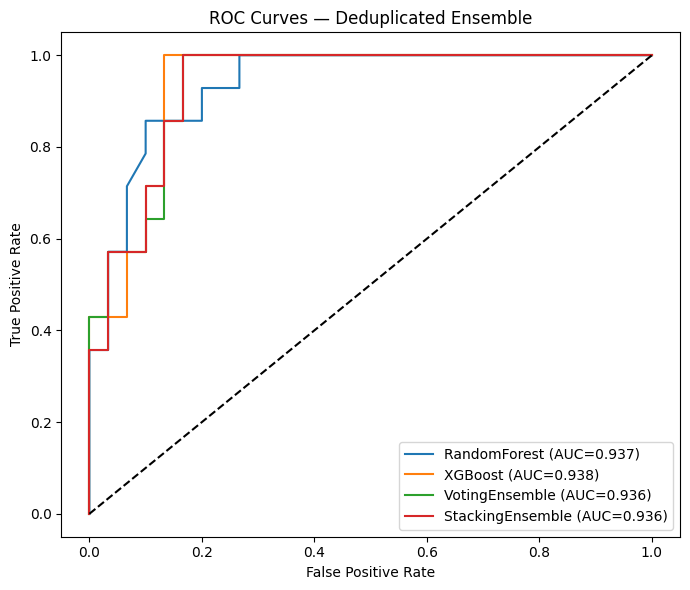

               name       auc        f1
0      RandomForest  0.936905  0.800000
1           XGBoost  0.938095  0.740741
2    VotingEnsemble  0.935714  0.714286
3  StackingEnsemble  0.935714  0.758621

Best Ensemble: XGBoost
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.77      0.71      0.74        14

    accuracy                           0.84        44
   macro avg       0.82      0.81      0.81        44
weighted avg       0.84      0.84      0.84        44

Saved final deduped ensemble: /work/siads_699_mads_capstone/data/models/ensemble_model_dedup_final.pkl
/root/venv/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import mlflow

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, classification_report
from xgboost import XGBClassifier

path = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(path)
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
df = df.replace(r"[\[\]]", "", regex=True)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="ignore")
for leak_col in ["crash_count", "avg_severity"]:
    if leak_col in df.columns:
        df.drop(columns=leak_col, inplace=True)
        print(f"Dropped leakage column: {leak_col}")

target = df["high_risk"].astype(int)
df_numeric = df.select_dtypes(include=[np.number]).copy()
df_numeric["high_risk"] = target
print(f"Numeric-only dataset: {df_numeric.shape[1]} columns")
numeric_cols = df_numeric.select_dtypes(include=["number"]).columns
before = len(df_numeric)
df_numeric = df_numeric.drop_duplicates(subset=numeric_cols, keep="first")
after = len(df_numeric)
print(f"Removed {before - after} duplicate numeric rows; {after} remain.")

X = df_numeric.drop(columns=["high_risk"])
y = df_numeric["high_risk"]
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = np.arange(len(df_numeric))
train_idx, test_idx = next(splitter.split(X, y, groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

imputer = SimpleImputer(strategy="mean")
rf = Pipeline([
    ("imputer", imputer),
    ("rf", RandomForestClassifier(
        n_estimators=200, random_state=42))
])

xgb = Pipeline([
    ("imputer", imputer),
    ("xgb", XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="auc", random_state=42))
])

voting_clf = VotingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)], voting="soft"
)

stack_model = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    print(f"{name:18s} | AUC={auc:.3f} | F1={f1:.3f}")
    return {"name": name, "auc": auc, "f1": f1, "y_pred_proba": y_pred_proba}

models = {
    "RandomForest": rf,
    "XGBoost": xgb,
    "VotingEnsemble": voting_clf,
    "StackingEnsemble": stack_model,
}

results = [evaluate_model(n, m, X_train, X_test, y_train, y_test) for n, m in models.items()]

plt.figure(figsize=(7, 6))
for r in results:
    fpr, tpr, _ = roc_curve(y_test, r["y_pred_proba"])
    plt.plot(fpr, tpr, label=f"{r['name']} (AUC={r['auc']:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.title("ROC Curves — Deduplicated Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame([{k: v for k, v in r.items() if k != "y_pred_proba"} for r in results])
print(metrics_df)
best = max(results, key=lambda r: r["auc"])
print(f"\nBest Ensemble: {best['name']}")
y_pred_best = (best["y_pred_proba"] > 0.5).astype(int)
print(classification_report(y_test, y_pred_best))

final_model = models[best["name"]]
final_model.fit(X, y)
model_path = "/work/siads_699_mads_capstone/data/models/ensemble_model_dedup_final.pkl"
joblib.dump(final_model, model_path)
print(f"Saved final deduped ensemble: {model_path}")

mlflow.set_tracking_uri("siads_699_mads_capstone/mlruns")
mlflow.set_experiment("WorkZone_Ensemble_Dedup_Final")
with mlflow.start_run(run_name="Ensemble_Dedup_Final"):
    for r in results:
        mlflow.log_metric(f"AUC_{r['name']}", r["auc"])
        mlflow.log_metric(f"F1_{r['name']}", r["f1"])
    mlflow.log_artifact(model_path)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>